### Ablation study: Loss $\mathcal L_\mathrm{geo}$ (no automatic evaluation)

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import DissimilarityMetrics
import ChannelChartingCore
import Evaluation

2024-12-04 14:31:16.086757: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 14:31:17.013419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import dichasus_cf0x

2024-12-04 14:31:18.612741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 14:31:18.670721: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 14:31:18.671112: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Load datapoints from file
This may take some time.

In [3]:
groundtruth_positions = []
csi_time_domain = []
timestamps = []

for csi, pos, time in dichasus_cf0x.trainingset.batch(1000):
    csi_time_domain.append(csi.numpy())
    groundtruth_positions.append(pos.numpy())
    timestamps.append(time.numpy())

csi_time_domain = np.concatenate(csi_time_domain)
groundtruth_positions = np.concatenate(groundtruth_positions)
timestamps = np.concatenate(timestamps)

MEASUREMENT_INTERVAL = 0.048
timestamps = timestamps - timestamps[0]
timestamps = np.round(timestamps / MEASUREMENT_INTERVAL) * MEASUREMENT_INTERVAL

2024-12-04 14:32:15.882322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


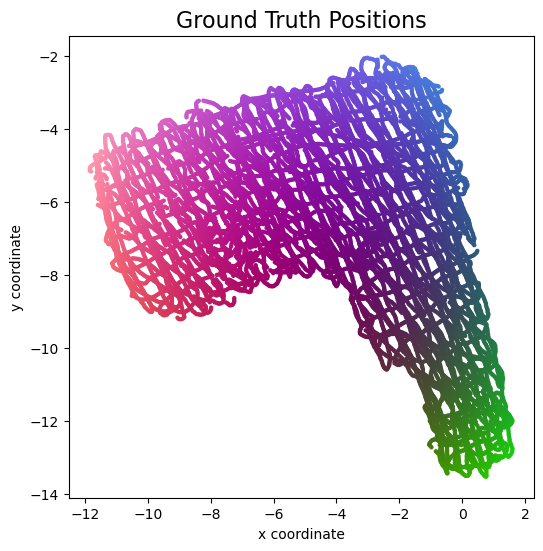

In [4]:
Evaluation.plot_colorized(groundtruth_positions, groundtruth_positions, title="Ground Truth Positions")

### Dissimilarity Metric

Ablation study: Edge weights are now deterministic, based on existing code from [dissimilarity-metric based Channel Charting tutorial](https://dichasus.inue.uni-stuttgart.de/tutorials/tutorial/dissimilarity-metric-channelcharting/).

In [5]:
@tf.function
def compute_adp_dissimilarity_matrix(csi_array):
	output = tf.TensorArray(tf.float32, size = csi_array.shape[0])

	powers = tf.einsum("lbrmt,lbrmt->lbt", csi_array, tf.math.conj(csi_array))
	for i in tf.range(csi_array.shape[0]):
		w = csi_array[i:,:,:,:]
		h = csi_array[i,:,:,:]

		dotproducts = tf.abs(tf.square(tf.einsum("brmt,lbrmt->lbt", tf.math.conj(h), w)))
		d_new = tf.math.reduce_sum(1 - dotproducts / tf.math.real(powers[i] * powers[i:]), axis = (1, 2))
		d = tf.concat([tf.zeros(i), tf.maximum(d_new, 0)], 0)

		output = output.write(i, d)

	dissim_upper_tri = output.stack()
	return dissim_upper_tri + tf.transpose(dissim_upper_tri)

adp_dissimilarity_matrix = compute_adp_dissimilarity_matrix(csi_time_domain).numpy()

In [6]:
# Compute timestamp-based dissimilarity matrix
timestamp_dissimilarity_matrix = np.abs(np.subtract.outer(timestamps, timestamps))

Text(0, 0.5, 'Number of Occurences')

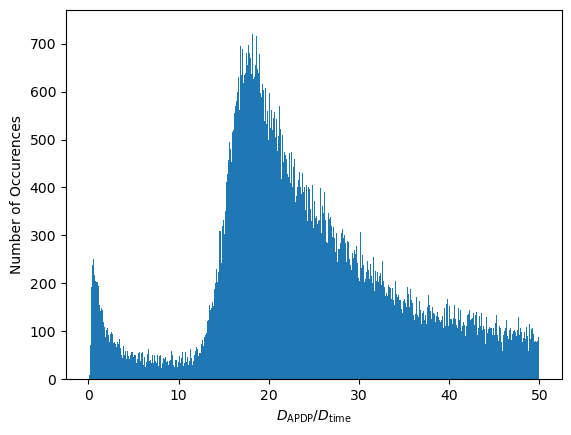

In [7]:
TIME_THRESHOLD = 2
small_time_dissimilarity_indices = np.logical_and(timestamp_dissimilarity_matrix < TIME_THRESHOLD, timestamp_dissimilarity_matrix > 0)
small_time_dissimilarities = timestamp_dissimilarity_matrix[small_time_dissimilarity_indices]
small_adp_dissimilarities = adp_dissimilarity_matrix[small_time_dissimilarity_indices]

n_bins = 1500

fig, ax1 = plt.subplots()
occurences, edges, patches = ax1.hist(small_adp_dissimilarities / small_time_dissimilarities, range = (0, 50), bins = n_bins)
ax1.set_xlabel("$D_\mathrm{APDP} / D_\mathrm{time}$")
ax1.set_ylabel("Number of Occurences")

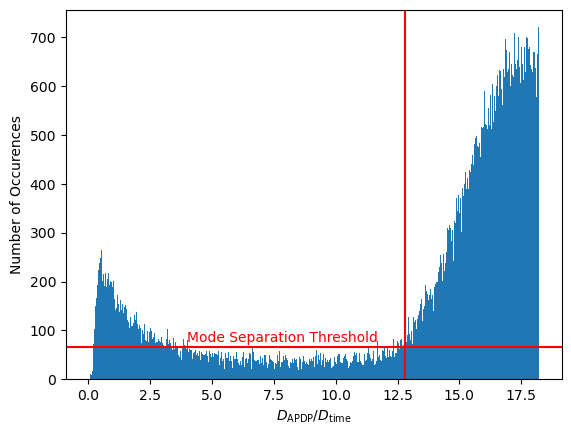

gamma =  12.816666603088379


In [8]:
bin_centers = edges[:-1] + np.diff(edges) / 2.
max_bin = np.argmax(occurences)
min_threshold = np.quantile(occurences[:max_bin], 0.5)

for threshold_bin in range(max_bin - 1, -1, -1):
	if occurences[threshold_bin] < min_threshold:
		break

scaling_factor = bin_centers[threshold_bin]

plt.bar(bin_centers[:max_bin], occurences[:max_bin], width = edges[1] - edges[0])
plt.axhline(y = min_threshold, color = 'r', linestyle = '-')
plt.text(4, min_threshold + 10, "Mode Separation Threshold", color = 'r',)
plt.axvline(x = scaling_factor, color = 'r', linestyle = '-')
plt.xlabel("$D_\mathrm{APDP} / D_\mathrm{time}$")
plt.ylabel("Number of Occurences")
plt.show()

print("gamma = ", scaling_factor)

In [9]:
# Fuse ADP-based and time-based dissimilarity matrices
dissimilarity_matrix_fused = np.minimum(adp_dissimilarity_matrix, timestamp_dissimilarity_matrix * scaling_factor)

In [10]:
class DeterministicDissimilarityMetric(DissimilarityMetrics.GaussianDissimilarityMetric):
    def __init__(self, dissimilarity_matrix, beta):
        self.dissimilarity_matrix = dissimilarity_matrix
        self.beta = beta
    
    def get_realization(self, output_matrix, variance_scale):
        output_matrix[:] = self.dissimilarity_matrix

    def mean_variance_along_path(self, paths, mask):
        dissimilarities = self.dissimilarity_matrix[paths[:,:-1], paths[:,1:]]
        dissimilarities_sum = np.sum(np.where(mask, dissimilarities, 0), axis = 1)

        return dissimilarities_sum, (dissimilarities_sum + self.beta) / 2
    
    def get_datapoint_count(self):
        return self.dissimilarity_matrix.shape[0]

    def is_contractable(self):
        return False

beta = np.quantile(dissimilarity_matrix_fused, 0.01)
dissimilarity_metric = DeterministicDissimilarityMetric(dissimilarity_matrix_fused, beta)

### Gaussian Dissimilarity Model and short path computation

This will also take some time

In [11]:
GDM = ChannelChartingCore.GaussianDissimilarityModel([dissimilarity_metric])
GDM.generate_short_paths(total_path_count = 40000, realization_count = 1)

  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


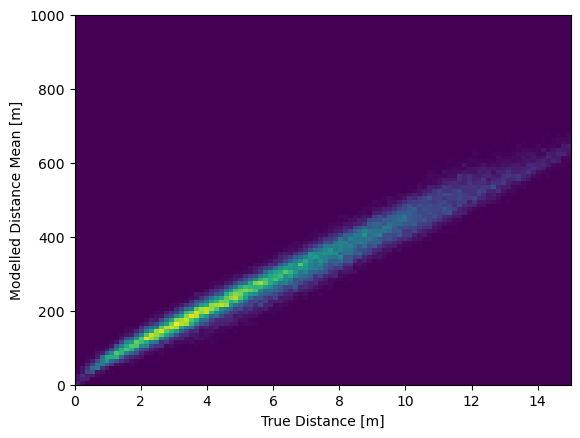

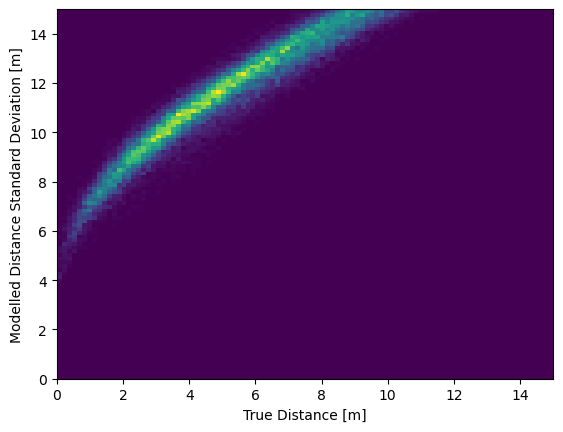

In [12]:
paths, path_hops, paths_d_mean, paths_d_variance = GDM.get_random_short_paths(50000, None)
groundtruth_distance_matrix = np.sqrt(np.sum((groundtruth_positions[:,np.newaxis,:] - groundtruth_positions[np.newaxis,:,:])**2, axis = -1))
groundtruth_dist = np.sum(groundtruth_distance_matrix[paths[:,:-1], paths[:,1:]], axis = 1).flatten()

plt.xlabel("True Distance [m]")
plt.ylabel("Modelled Distance Mean [m]")
plt.hist2d(groundtruth_dist, paths_d_mean, bins = 100, range = [(0, 15), (0, 1000)])
plt.show()

plt.xlabel("True Distance [m]")
plt.ylabel("Modelled Distance Standard Deviation [m]")
plt.hist2d(groundtruth_dist, np.sqrt(paths_d_variance), bins = 100, range = [(0, 15), (0, 15)])
plt.show()

### Channel Chart Training

Feel free to tweak the hyperparameters!

In [13]:
MIN_BATCH_SIZE = 500
MAX_BATCH_SIZE = 4000
LEARNING_RATE_INITIAL = 1.5e-2
LEARNING_RATE_FINAL = 1e-2
MAX_HOPLENGTH = 1500.0
MIN_HOPLENGTH = 7.0
MAX_PATHHOPS = 50
TRAINING_BATCHES = 3000

Ablation Study: Disable acceleration constraint by setting `ACCELERATION_WEIGHT = 0`

In [14]:
ACCELERATION_MEAN = 0.0
ACCELERATION_VARIANCE = 0.5
ACCELERATION_WEIGHT = 0 #1e-4

Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733322907.229608     151 service.cc:145] XLA service 0x76603c1a6bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733322907.229671     151 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 14:35:07.378285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 14:35:07.722942: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 14:35:08.700728: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:38 33ms/step - loss: 514.7191 - metric: 0.0000e+00

I0000 00:00:1733322910.222430     151 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 199/3000 ━━━━━━━━━━━━━━━━━━━━ 1:59 43ms/step - loss: 254.2794 - metric: 0.0000e+00

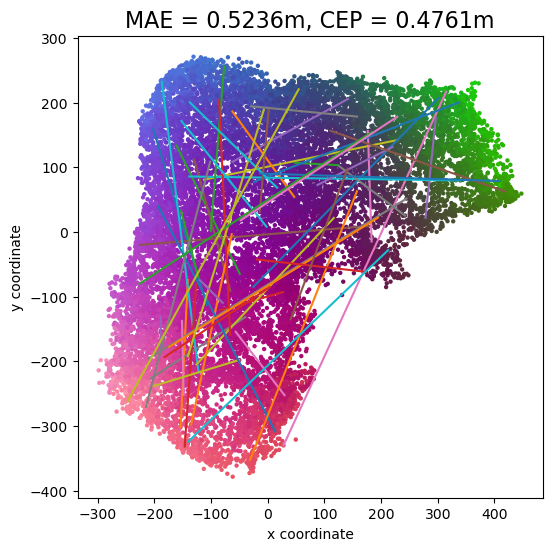

 398/3000 ━━━━━━━━━━━━━━━━━━━━ 1:53 44ms/step - loss: 165.9768 - metric: 0.0000e+00

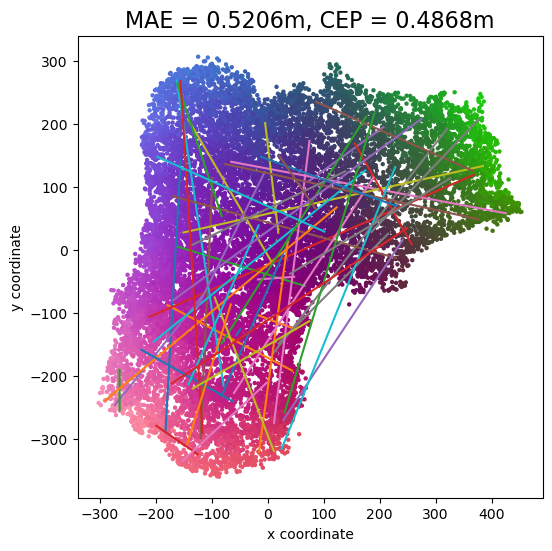

 598/3000 ━━━━━━━━━━━━━━━━━━━━ 1:44 44ms/step - loss: 126.4837 - metric: 0.0000e+00

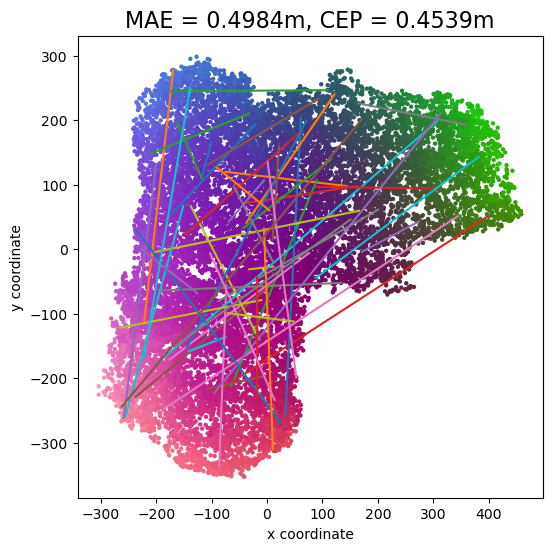

 799/3000 ━━━━━━━━━━━━━━━━━━━━ 1:35 44ms/step - loss: 103.6058 - metric: 0.0000e+00

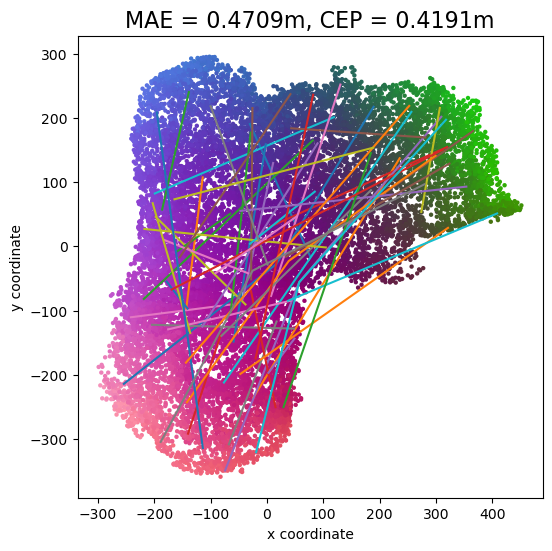

 999/3000 ━━━━━━━━━━━━━━━━━━━━ 1:27 44ms/step - loss: 88.6189 - metric: 0.0000e+00

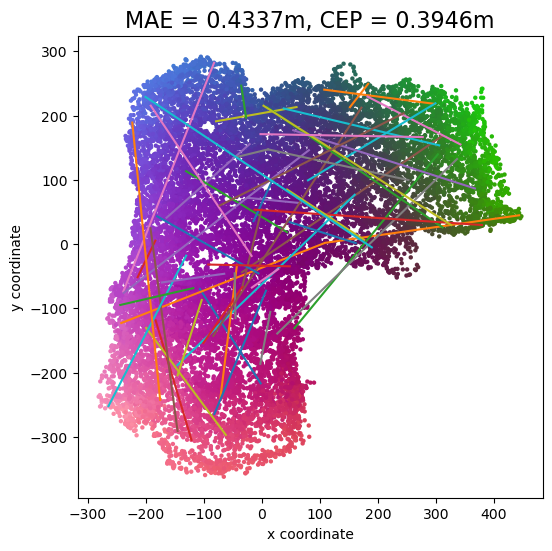

1198/3000 ━━━━━━━━━━━━━━━━━━━━ 1:19 44ms/step - loss: 77.9614 - metric: 0.0000e+00

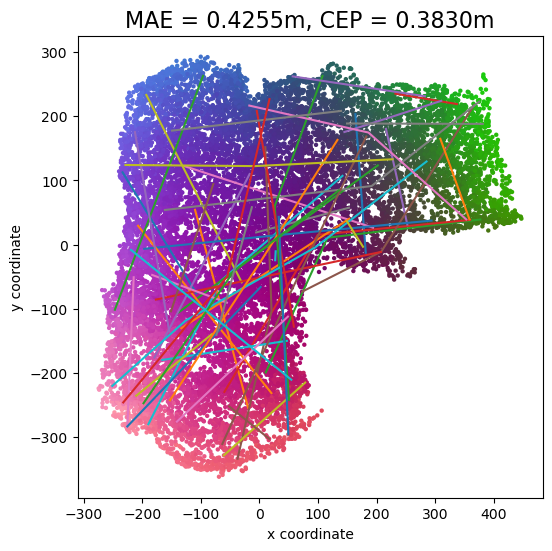

1398/3000 ━━━━━━━━━━━━━━━━━━━━ 1:13 46ms/step - loss: 69.8851 - metric: 0.0000e+00

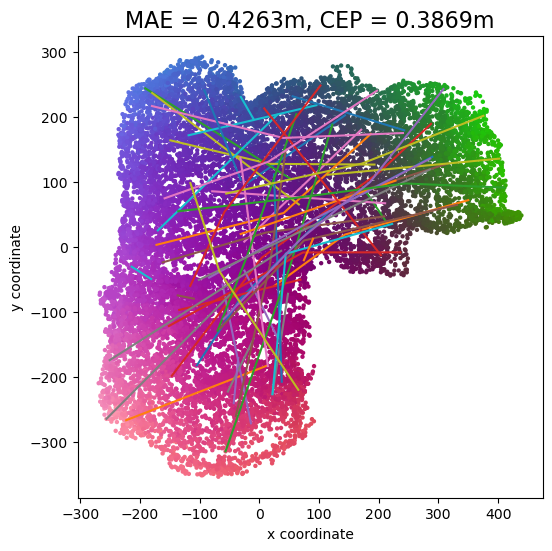

1599/3000 ━━━━━━━━━━━━━━━━━━━━ 1:03 45ms/step - loss: 63.5304 - metric: 0.0000e+00

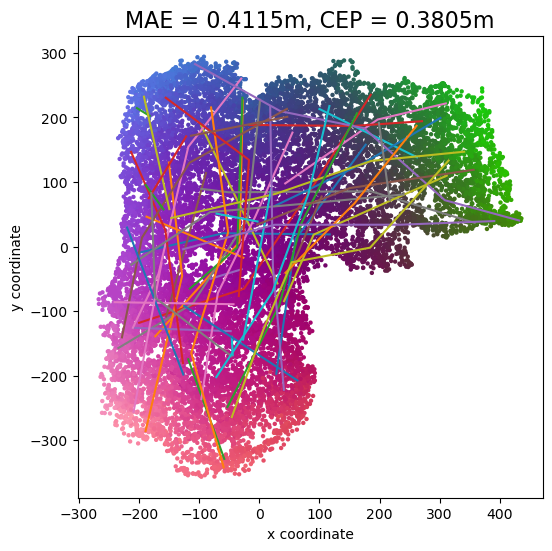

1799/3000 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - loss: 58.4318 - metric: 0.0000e+00

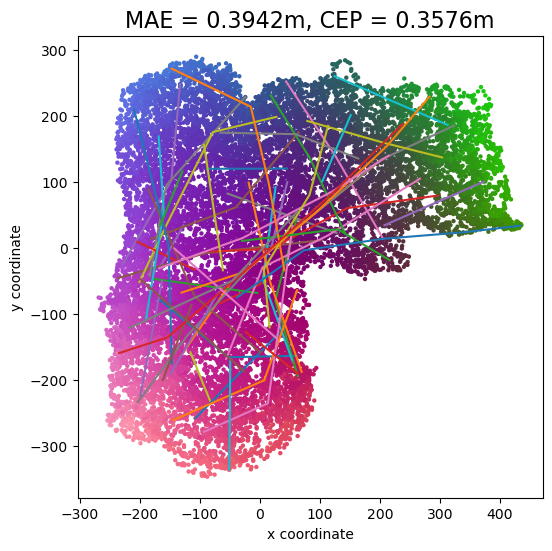

1998/3000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - loss: 54.2410 - metric: 0.0000e+00

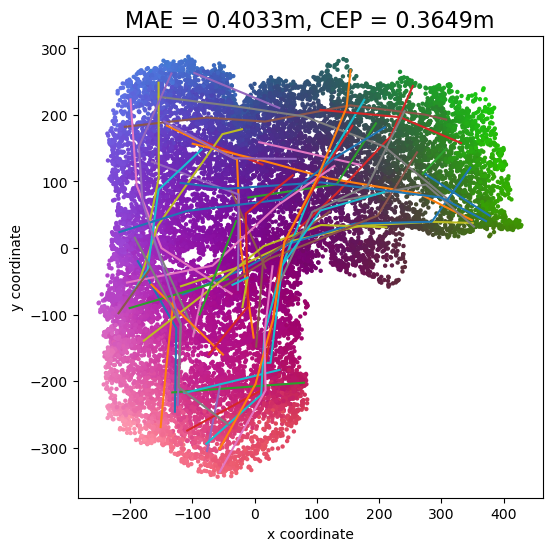

2198/3000 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - loss: 50.6962 - metric: 0.0000e+00

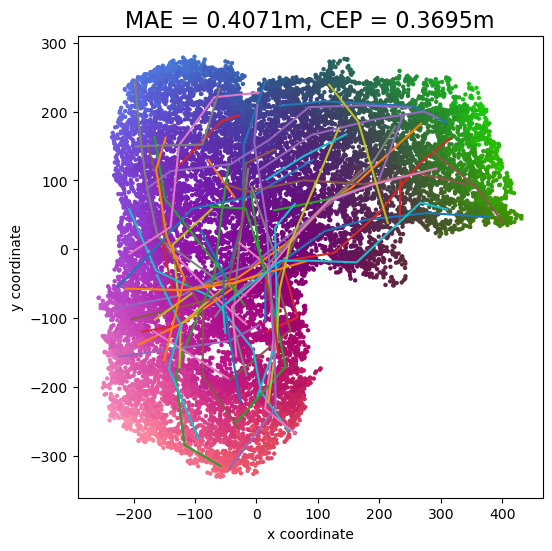

2399/3000 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - loss: 47.6542 - metric: 0.0000e+00

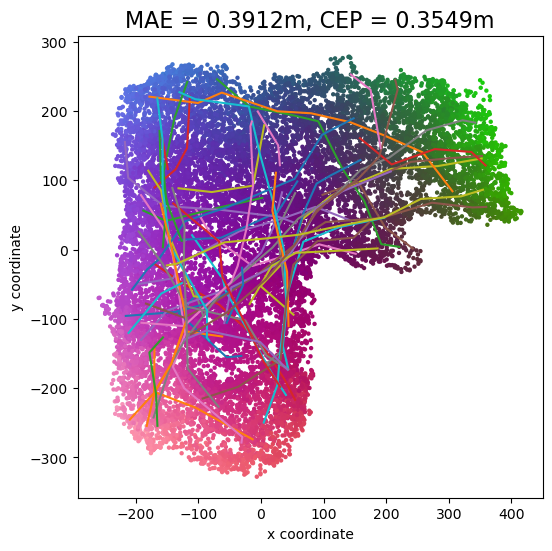

2599/3000 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 45.0364 - metric: 0.0000e+00

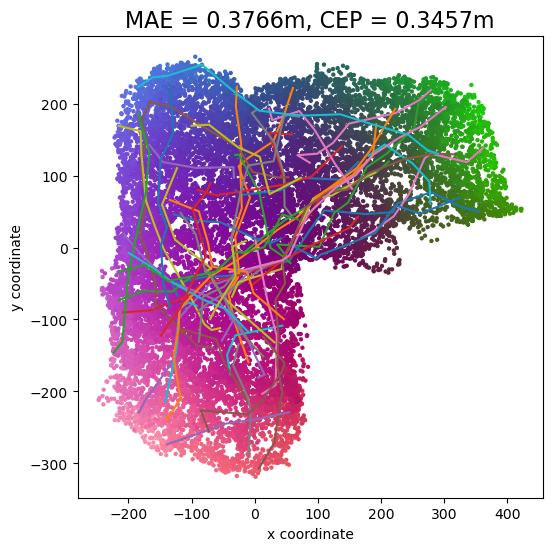

2798/3000 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 42.7593 - metric: 0.0000e+00

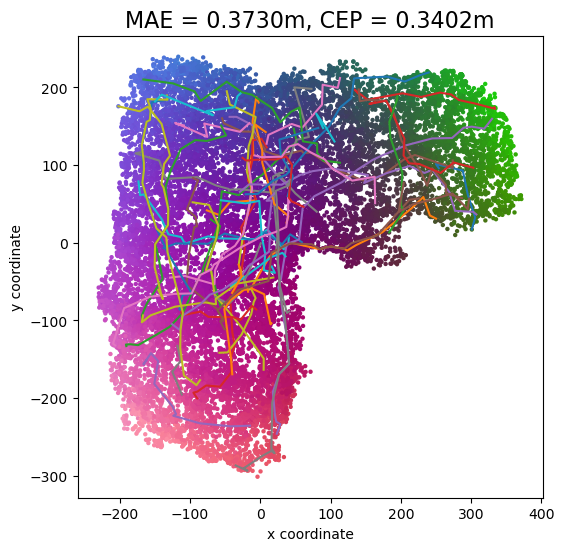

2998/3000 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 40.7371 - metric: 0.0000e+00

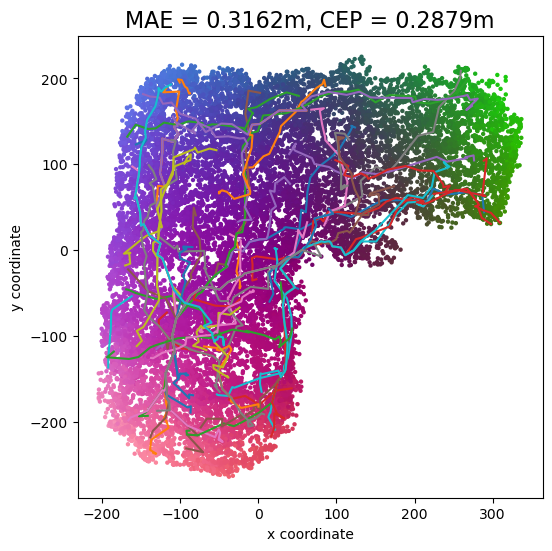

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 142s 46ms/step - loss: 40.7085 - metric: 0.0000e+00


In [15]:
plot_callback = Evaluation.PlotChartCallback(groundtruth_positions, csi_time_domain.shape[0], max_hops = MAX_PATHHOPS)
cc = ChannelChartingCore.ChannelChart(GDM, csi_time_domain, timestamps, min_batch_size = MIN_BATCH_SIZE, max_batch_size = MAX_BATCH_SIZE, learning_rate_initial = LEARNING_RATE_INITIAL, learning_rate_final = LEARNING_RATE_FINAL, max_hoplength = MAX_HOPLENGTH, min_hoplength = MIN_HOPLENGTH, randomize_pathhops = False, training_batches = TRAINING_BATCHES, plot_callback = plot_callback, acceleration_mean = ACCELERATION_MEAN, acceleration_variance = ACCELERATION_VARIANCE, acceleration_weight = ACCELERATION_WEIGHT, max_pathhops = MAX_PATHHOPS)

### Evaluation on Training Set

This is a valid evaluation metric for a self-supervised training technique like Channel Charting.

In [16]:
channel_chart_positions = cc.predict(csi_time_domain)

652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [17]:
ct, tw, ks = Evaluation.ct_tw_ks_on_subset(groundtruth_positions, channel_chart_positions)
print(f"CT: {ct:.4f}\nTW: {tw:.4f}\nKS: {ks:.4f}")

CT: 0.9973
TW: 0.9968
KS: 0.0698


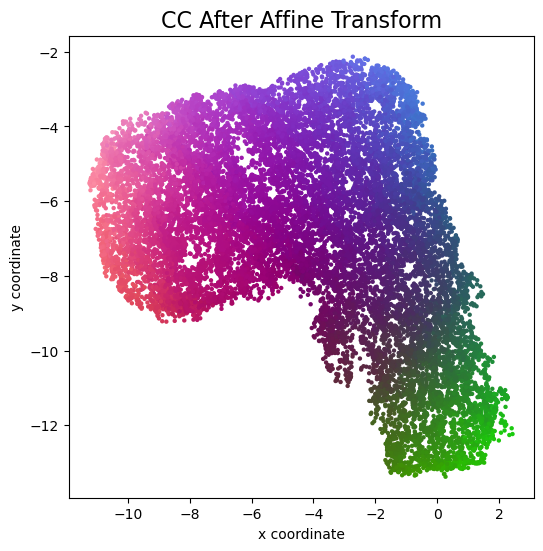

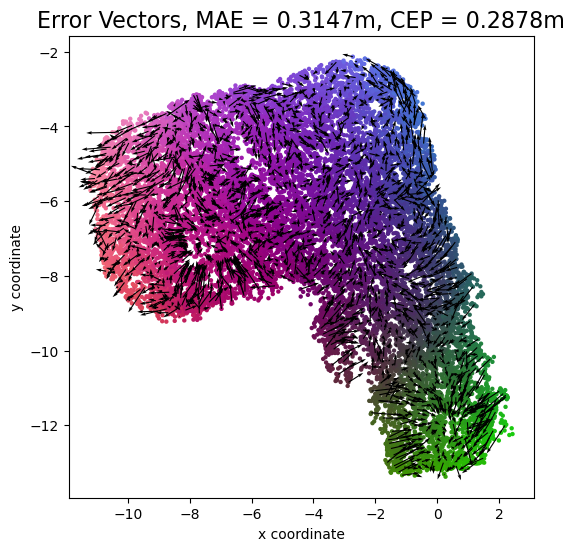

In [18]:
channel_chart_positions_transformed, errorvectors, errors, mae, cep = Evaluation.mean_absolute_error_transformed(groundtruth_positions, channel_chart_positions)
Evaluation.plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = "CC After Affine Transform")

nth_errorvector = 10
Evaluation.plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = f"Error Vectors, MAE = {mae:.4f}m, CEP = {cep:.4f}m", show = False)
plt.quiver(channel_chart_positions_transformed[::nth_errorvector, 0], channel_chart_positions_transformed[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.show()

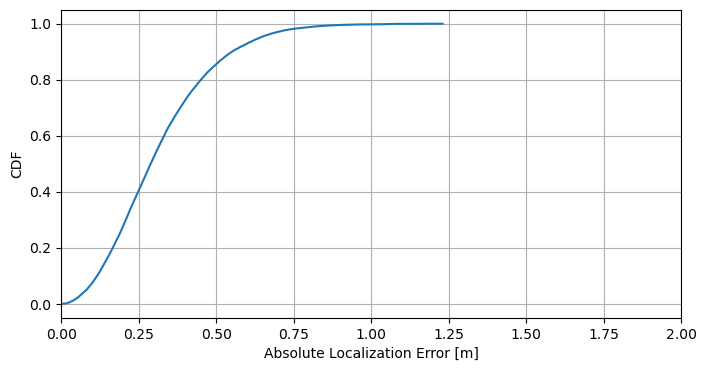

In [19]:
count, bins_count = np.histogram(errors, bins=200)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

bins_count[0] = 0
cdf = np.append([0], cdf)

plt.figure(figsize=(8, 4))
plt.plot(bins_count, cdf)
plt.xlim((0, 2))
plt.xlabel("Absolute Localization Error [m]")
plt.ylabel("CDF")
plt.grid()
plt.show()

### Evaluate on Test Set
The performance on the test set is very similar to the performance we observe for the training set, as one would hope.

In [20]:
test_set_groundtruth_positions = []
test_set_csi_time_domain = []

for csi, pos, time in dichasus_cf0x.testset.batch(1000):
    test_set_csi_time_domain.append(csi.numpy())
    test_set_groundtruth_positions.append(pos.numpy())

test_set_csi_time_domain = np.concatenate(test_set_csi_time_domain)
test_set_groundtruth_positions = np.concatenate(test_set_groundtruth_positions)

2024-12-04 14:38:01.785745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
test_set_channel_chart_positions = cc.predict(test_set_csi_time_domain)

652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [22]:
ts_ct, ts_tw, ts_ks = Evaluation.ct_tw_ks_on_subset(test_set_groundtruth_positions, test_set_channel_chart_positions)
print(f"CT: {ts_ct:.4f}\nTW: {ts_tw:.4f}\nKS: {ts_ks:.4f}")

CT: 0.9974
TW: 0.9969
KS: 0.0700


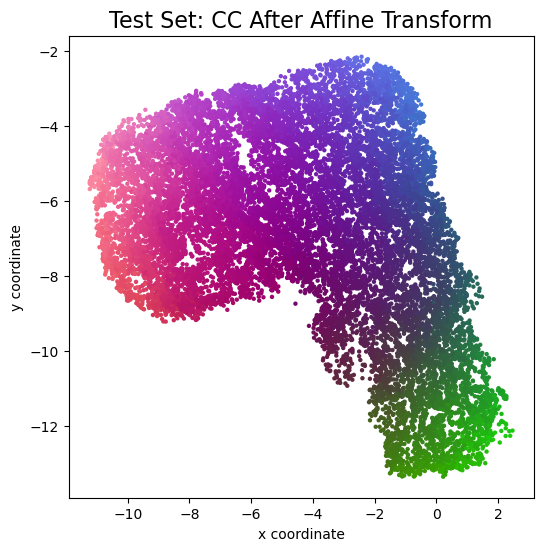

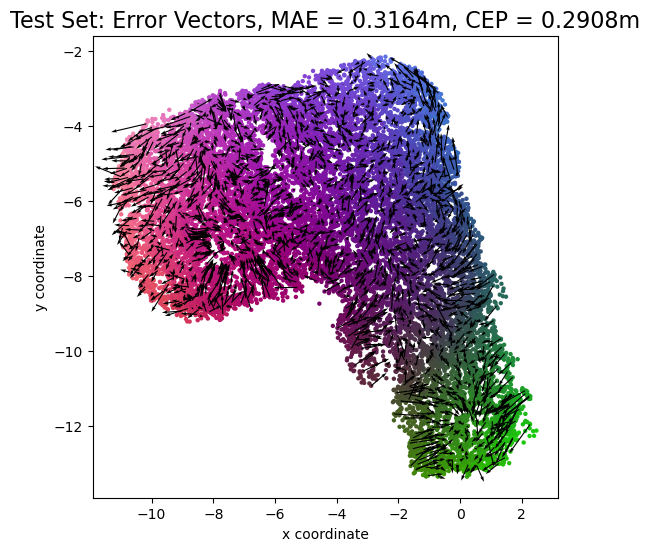

In [23]:
test_set_channel_chart_positions_transformed, ts_errorvectors, ts_errors, ts_mae, ts_cep = Evaluation.mean_absolute_error_transformed(test_set_groundtruth_positions, test_set_channel_chart_positions)
Evaluation.plot_colorized(test_set_channel_chart_positions_transformed, test_set_groundtruth_positions, title = "Test Set: CC After Affine Transform")

nth_errorvector = 10
Evaluation.plot_colorized(test_set_channel_chart_positions_transformed, test_set_groundtruth_positions, title = f"Test Set: Error Vectors, MAE = {ts_mae:.4f}m, CEP = {ts_cep:.4f}m", show = False)
plt.quiver(test_set_channel_chart_positions_transformed[::nth_errorvector, 0], test_set_channel_chart_positions_transformed[::nth_errorvector, 1], ts_errorvectors[::nth_errorvector, 0], ts_errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.show()